In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import os

In [2]:
# Load CSV file with image labels
data_path = "C:\\Users\\USER\\Documents\\4-2  Thesis\\Dataset\\train_validate_set.csv"
image_dir = "C:\\Users\\USER\\Documents\\4-2  Thesis\\train_validation(1)"

In [3]:
# Load and preprocess the dataset
data = pd.read_csv(data_path)
data['file_path'] = data['image_id'].apply(lambda x: os.path.join(image_dir, x+".jpg"))
data['label'] = data['label'].astype(str)

In [4]:
# Parameters
img_height, img_width = 224, 224  # Image dimensions
batch_size = 32
epochs = 30

In [5]:
# Prepare Image Data Generator
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

train_gen = data_gen.flow_from_dataframe(
    dataframe=data,
    directory=image_dir,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = data_gen.flow_from_dataframe(
    dataframe=data,
    directory=image_dir,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6523 validated image filenames belonging to 4 classes.
Found 1630 validated image filenames belonging to 4 classes.


In [6]:
# # Split data into training and validation sets
# train_ids, val_ids, train_labels, val_labels = train_test_split(
#     image_ids, categorical_labels, test_size=0.12, random_state=42
# )

In [7]:
# Load VGG19 model with pretrained weights and exclude top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [8]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(4, activation='softmax')(x)  # Adjust output layer for 4 classes

model = Model(inputs=base_model.input, outputs=out)

In [10]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=out)

In [11]:

# Fine-tune the base model by unfreezing the last few layers
for layer in base_model.layers[-5:]:  # Adjust the number based on experimentation
    layer.trainable = True

In [12]:
# Compile the model with a slightly lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Add callbacks for dynamic learning rate adjustment and early stopping
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

In [14]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_steps=val_gen.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/30
203/203 [==============================] - 16s 58ms/step - loss: 0.6817 - accuracy: 0.7456 - val_loss: 0.6698 - val_accuracy: 0.7563 - lr: 1.0000e-04
Epoch 2/30
203/203 [==============================] - 11s 53ms/step - loss: 0.5943 - accuracy: 0.7669 - val_loss: 0.5573 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/30
203/203 [==============================] - 11s 53ms/step - loss: 0.5236 - accuracy: 0.7897 - val_loss: 0.5137 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 4/30
203/203 [==============================] - 11s 51ms/step - loss: 0.4878 - accuracy: 0.8077 - val_loss: 0.5875 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 5/30
203/203 [==============================] - 10s 51ms/step - loss: 0.4424 - accuracy: 0.8199 - val_loss: 0.5655 - val_accuracy: 0.7962 - lr: 1.0000e-04
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
203/203 [==============================] - 11s 51ms/step - loss: 0.3740 - accuracy: 0.8533 - val_loss: 0.54

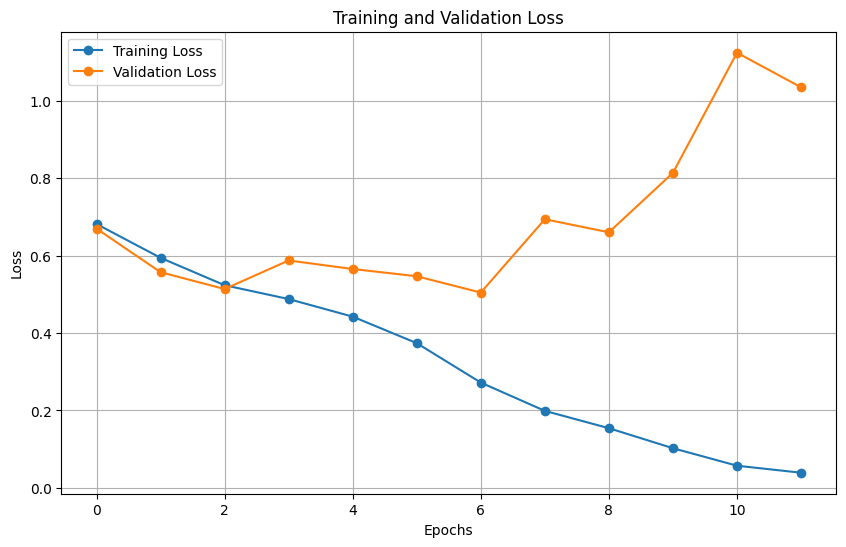

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

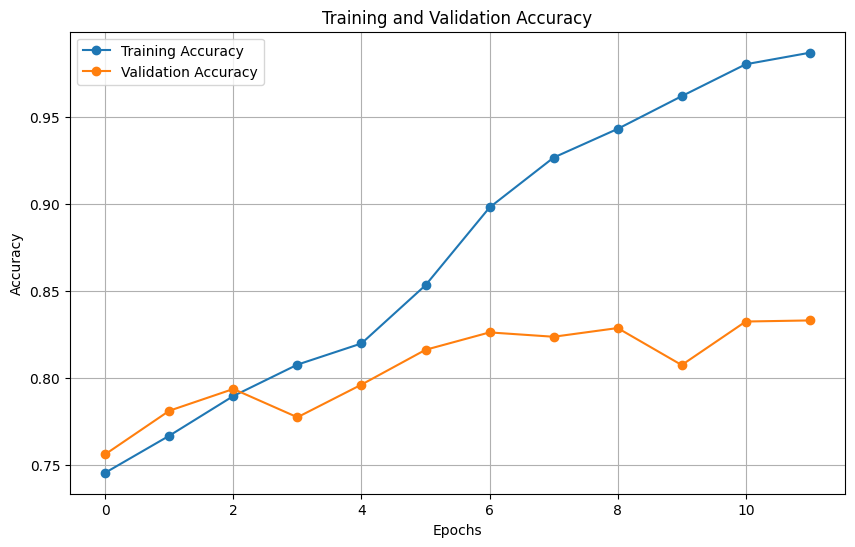

In [16]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy(history)

In [18]:
# Save the model
model.save('VGG19_Model_1.h5')

In [17]:
# Evaluate the model
eval_result = model.evaluate(val_gen)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

51/51 [==============================] - 3s 56ms/step - loss: 0.5120 - accuracy: 0.8245
Validation Loss: 0.512013852596283, Validation Accuracy: 0.8245398998260498
